# Goal

The goal of this notebook is to explore the existing ways to generate time series together with the way to evaluate the generated time series. Then in the end, I will explore using a simple DDPM model in the signature space and check whether the output makes sense.

Models included as baseline:
1. Sig-WGAN
2. TimeVQVAE
3. TimeGAN

# General Setup

First explore the dataset that's commonly used for time series generation tasks. In this case. The datasets are downloaded or geneated; if downloaded, then the links are:
- [HFT stock market data](https://github.com/jonathancornelissen/highfrequency/raw/master/data-raw/OxfordManRealizedVolatilityIndices.zip)
- [MIT arrhythmia-database](https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip)

In [18]:
import pandas as pd
import wfdb
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

In [7]:
class Pipeline:
    def __init__(self, steps):
        """ Pre- and postprocessing pipeline. """
        self.steps = steps

    def transform(self, x, until=None):
        x = x.clone()
        for n, step in self.steps:
            if n == until:
                break
            x = step.transform(x)
        return x

    def inverse_transform(self, x, until=None):
        for n, step in self.steps[::-1]:
            if n == until:
                break
            x = step.inverse_transform(x)
        return x

In [11]:

class StandardScalerTS():
    """ Standard scales a given (indexed) input vector along the specified axis. """

    def __init__(self, axis=(1)):
        self.mean = None
        self.std = None
        self.axis = axis

    def transform(self, x):
        if self.mean is None:
            self.mean = torch.mean(x, dim=self.axis)
            self.std = torch.std(x, dim=self.axis)
        return (x - self.mean.to(x.device)) / self.std.to(x.device)

    def inverse_transform(self, x):
        return x * self.std.to(x.device) + self.mean.to(x.device)


In [8]:
def get_mit_arrythmia_dataset(filenames):
    DATA_DIR = '../src/data/mit-bih-arrhythmia-database-1.0.0/'
    records = list()
    for fn in filenames:
        records.append(wfdb.rdsamp(os.path.join(DATA_DIR, fn), sampto=3000)[0][None, ...])
    records = np.concatenate(records, axis=0)
    records = np.log(5 * (records - records.min() + 1))
    data_raw = torch.from_numpy(records).float()
    pipeline = Pipeline(steps=[('standard_scale', StandardScalerTS(axis=(0, 1)))])
    data_pre = pipeline.transform(data_raw)
    return pipeline, data_raw, data_pre

In [9]:
mit_data_generator = [('id=100', dict(filenames=['100']))]

In [12]:
mit_data_pipeline, mit_data_raw, mit_data_processed = get_mit_arrythmia_dataset(["100"])

In [14]:
mit_data_raw.shape

torch.Size([1, 3000, 2])

In [19]:
mit_data_raw[0,:,0]

tensor([2.0149, 2.0149, 2.0149,  ..., 2.5337, 2.5533, 2.5014])

<Axes: >

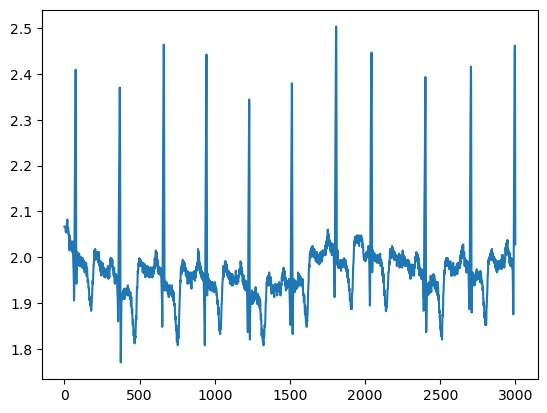

In [22]:
sns.lineplot(mit_data_raw[0,:,1])

In [23]:
# the stock market dataset 
def get_equities_dataset(assets=('SPX', 'DJI'), with_vol=True):
    """
    Get different returns series.
    """
    oxford = pd.read_csv('../src/data/oxfordmanrealizedvolatilityindices.csv')

    start = '2005-01-01 00:00:00+01:00'
    end = '2020-01-01 00:00:00+01:00'

    if assets == ('SPX',):
        df_asset = oxford[oxford['Symbol'] == '.SPX'].set_index(['Unnamed: 0'])  # [start:end]
        price = np.log(df_asset[['close_price']].values)
        rtn = (price[1:] - price[:-1]).reshape(1, -1, 1)
        vol = np.log(df_asset[['medrv']].values[-rtn.shape[1]:]).reshape(1, -1, 1)
        data_raw = np.concatenate([rtn, vol], axis=-1)
    elif assets == ('SPX', 'DJI'):
        df_spx = oxford[oxford['Symbol'] == '.SPX'].set_index(['Unnamed: 0'])[start:end]
        df_dji = oxford[oxford['Symbol'] == '.DJI'].set_index(['Unnamed: 0'])[start:end]
        index = df_dji.index.intersection(df_spx.index)
        df_dji = df_dji.loc[index]
        df_spx = df_spx.loc[index]
        price_spx = np.log(df_spx[['close_price']].values)
        rtn_spx = (price_spx[1:] - price_spx[:-1]).reshape(1, -1, 1)
        vol_spx = np.log(df_spx[['medrv']].values).reshape(1, -1, 1)
        price_dji = np.log(df_dji[['close_price']].values)
        rtn_dji = (price_dji[1:] - price_dji[:-1]).reshape(1, -1, 1)
        vol_dji = np.log(df_dji[['medrv']].values).reshape(1, -1, 1)
        data_raw = np.concatenate([rtn_spx, vol_spx[:, 1:], rtn_dji, vol_dji[:, 1:]], axis=-1)
    else:
        raise NotImplementedError()
    data_raw = torch.from_numpy(data_raw).float()
    pipeline = Pipeline(steps=[('standard_scale', StandardScalerTS(axis=(0, 1)))])
    data_preprocessed = pipeline.transform(data_raw)
    return pipeline, data_raw, data_preprocessed

In [24]:
stock_pipeline, stock_raw, stock_processed = get_equities_dataset()

In [25]:
stock_raw.shape

torch.Size([1, 3764, 4])

In [27]:
# from the code we have rtn_spx, vol_spx, rtn_dji, vol_dji
stock_processed.shape

torch.Size([1, 3764, 4])

In [33]:
stock_raw[0,:,0]

tensor([-1.1231e-02, -3.6929e-03,  3.0952e-03,  ..., -3.3950e-05,
        -5.7046e-03,  2.6938e-03])

In [34]:
stock_raw[0,:,2]

tensor([-0.0087, -0.0029,  0.0020,  ...,  0.0007, -0.0062,  0.0021])

Text(0.5, 1.0, 'VOL_DJI')

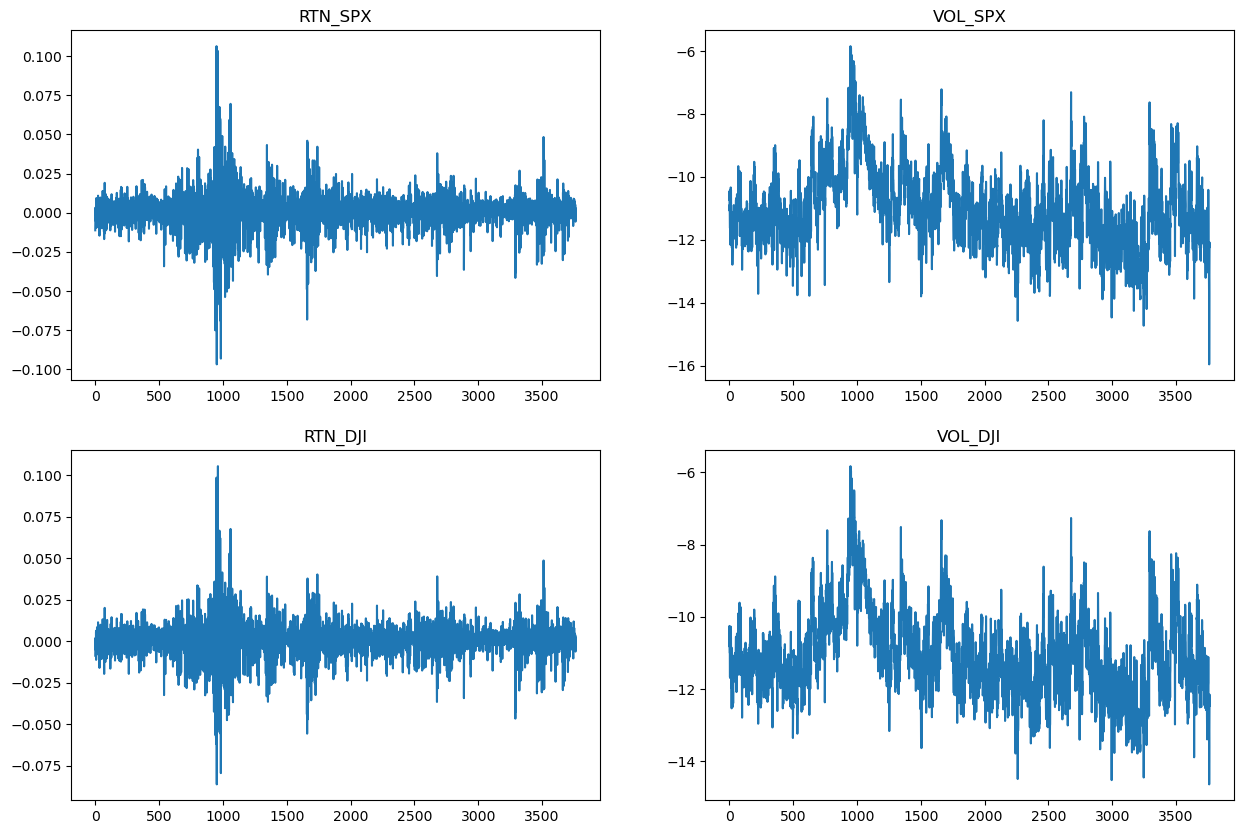

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
sns.lineplot(stock_raw[0, :, 0], ax=ax[0,0])
sns.lineplot(stock_raw[0, :, 1], ax=ax[0,1])
sns.lineplot(stock_raw[0, :, 2], ax=ax[1,0])
sns.lineplot(stock_raw[0, :, 3], ax=ax[1,1])
ax[0,0].set_title("RTN_SPX")
ax[0,1].set_title("VOL_SPX")
ax[1,0].set_title("RTN_DJI")
ax[1,1].set_title("VOL_DJI")

In addition, there's also the dataset that's more volatile, from Crypto Exchanges, available [here](https://github.com/David-Woroniuk/Historic_Crypto)

# Training Pipeline

The training pipeline in the case of conditional generation is straightforward; the time series is sliced into chunks of __past__ and __future__, where __past__ is used as the training slice and __future__ as the target slice. 

For SigWGAN, the pipeline is the following:
1. Transform the time series $X_{tr}$ into $X_{past}, X_{future}$.
2. Apply signature transform (signatory) to obtain $S_{past}, S_{future}$.
3. Fit a linear regression model on $S_{past}, S_{future}$ and generate $S_{pred}$.
4. Use gnerator network $G_\theta$ on $X_{past}$ to create fake samples $X_{fake}$.
5. Apply signature transform to $X_{fake}$ to generate $S_{fake}$.
6. Compute the Wasserstein-1 metrics between $S_{fake}$ and $S_{pred}$ and minimize.

One would imagine that similar things can be done with diffusion model for conditional generation, where we can have two options:

__option 1__: (__DM__) vanilla diffusion model; in this case, simply use $X_{past}$ as the conditional information and geneate $X_{future}$.

__option 2__: (__SDM__) signature diffusion model; in this case, use $S_{past}$ as the conditional information and generate $X_{future}$ (or $S_{future}$ then inverse transform)
    - If not an inverse transform, maybe a decoder.